Importing Necessary Libraries

In [3]:
import os
import shutil
import glob
from tqdm import tqdm

import tensorflow as tf
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout,Input,Flatten,Dense,MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Data Augumentation
import cv2
import numpy as np

Creating Data Generator for Train,Test and Validation data.

And found number of images belonging to 2 folders.

In [4]:
batchsize=8
train_datagen= ImageDataGenerator(rescale=1./255, rotation_range=0.2,shear_range=0.2,
    zoom_range=0.2,width_shift_range=0.2,
    height_shift_range=0.2, validation_split=0.2)

train_data= train_datagen.flow_from_directory(r'F:\CVPR\Drowsiness_Detection\Data\train',
                                target_size=(80,80),batch_size=batchsize,class_mode='binary',subset='training' )

validation_data= train_datagen.flow_from_directory(r'F:\CVPR\Drowsiness_Detection\Data\train',
                                target_size=(80,80),batch_size=batchsize,class_mode='binary', subset='validation')

test_datagen = ImageDataGenerator(rescale=1./255)

test_data = test_datagen.flow_from_directory(r'F:\CVPR\Drowsiness_Detection\Data\test',
                                target_size=(80,80),batch_size=batchsize,class_mode='binary', shuffle=False)

Found 61128 images belonging to 2 classes.
Found 15281 images belonging to 2 classes.
Found 8489 images belonging to 2 classes.


Creating Transfer learning model ,keeping the base model as MobileNet, which is pre-trained on the ImageNet dataset. 

The top layer of the base model is removed and a custom classifier is added on top of the base model to fit it to the specific task.

In [5]:
from tensorflow.keras import regularizers
# Defining the regularizer for the dense layers
reg = regularizers.l2(0.001) #L2 regularization is used to prevent overfitting with the strength of 0.001
# Creating the model architecture
base_model = MobileNet(include_top=False, weights='imagenet',input_tensor=Input(shape=(80,80,3)))
x = base_model.output
x = Flatten()(x) #Flattens the output tensor from the base model into a 1D array.
x = Dense(64, activation='relu', kernel_regularizer=reg)(x)
x = Dropout(0.5)(x)  #to prevent overfitting.
predictions = Dense(1, activation='sigmoid')(x)
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)
# Setting the base model layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False  #Freezes all the layers of the base model so that their pre-trained weights will not be updated during training.
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80, 80, 3)]       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 81, 81, 3)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 40, 40, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 40, 40, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 40, 40, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 40, 40, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 40, 40, 32)       

Saving the model as .h5 file

In [6]:
model.save('DD_using_mobilenet_model.h5')

Seting up three different callback functions. 


1.ModelCheckpoint: This callback saves the model weights to a file after every epoch where the validation loss has decreased. By setting save_best_only=True, it only saves the weights if the new model is better than the previous best model based on validation loss.


2.EarlyStopping: This callback stops training if the validation loss doesn't improve for a certain number of epochs (patience parameter). It restores the weights of the best model found during training based on validation loss.


3.ReduceLROnPlateau: This callback reduces the learning rate if the validation loss doesn't improve for a certain number of epochs (patience parameter). By doing so, it helps the optimizer to converge to a better solution by taking smaller steps in the weight space. The monitor parameter specifies which metric to monitor for improvement, in this case the validation loss.

In [7]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint(r'C:\Users\USER\.conda\DD_using_mobilenet_model.h5',
                            monitor='val_loss',save_best_only=True,verbose=3)

earlystop = EarlyStopping(monitor = 'val_loss', patience=50, verbose= 3, restore_best_weights=True)

learning_rate = ReduceLROnPlateau(monitor= 'val_loss', patience=3, verbose= 3, )

callbacks=[checkpoint,earlystop,learning_rate]

Compiling the model with the optimizer, loss function, and metrics.Adam optimizer adaptively adjust the learning rate.Binary_crossentropy measures the difference between the predicted output and the actual output for each example in the training data in either 0 or 1.

Training the model with batch size =8 and 50 epocs.

In [8]:
model.compile(optimizer='Adam', loss='binary_crossentropy',metrics=['accuracy'])

batchsize=8
train_model = model.fit(train_data,steps_per_epoch=train_data.samples//batchsize,
                   validation_data=validation_data,
                   validation_steps=validation_data.samples//batchsize,
                   callbacks=callbacks,
                    epochs=50)

Epoch 1/50
7641/7641 [==============================] - ETA: 0s - loss: 0.3284 - accuracy: 0.9057
Epoch 00001: val_loss improved from inf to 0.41901, saving model to C:\Users\USER\.conda\DD_using_mobilenet_model.h5
7641/7641 [==============================] - 761s 100ms/step - loss: 0.3284 - accuracy: 0.9057 - val_loss: 0.4190 - val_accuracy: 0.8690
Epoch 2/50
7641/7641 [==============================] - ETA: 0s - loss: 0.3256 - accuracy: 0.9110
Epoch 00002: val_loss improved from 0.41901 to 0.38646, saving model to C:\Users\USER\.conda\DD_using_mobilenet_model.h5
7641/7641 [==============================] - 587s 77ms/step - loss: 0.3256 - accuracy: 0.9110 - val_loss: 0.3865 - val_accuracy: 0.8715
Epoch 3/50
7641/7641 [==============================] - ETA: 0s - loss: 0.3176 - accuracy: 0.9115
Epoch 00003: val_loss improved from 0.38646 to 0.38031, saving model to C:\Users\USER\.conda\DD_using_mobilenet_model.h5
7641/7641 [==============================] - 629s 82ms/step - loss: 0.3176

In [10]:
model.save('DD_using_mobilenet_model.h5')

Evaluating the performance of the trained model on validation data .

In [11]:
val_loss , val_accuracy = model.evaluate(validation_data)
print(val_accuracy)
print(val_loss)

1911/1911 [==============================] - 79s 41ms/step - loss: 0.3013 - accuracy: 0.8860
0.886002242565155
0.30131518840789795


Evaluating the performance of the trained model on Training data .

In [12]:
train_loss , train_accuracy = model.evaluate(train_data)
print(train_accuracy)
print(train_loss)

7641/7641 [==============================] - 310s 41ms/step - loss: 0.1710 - accuracy: 0.9440
0.9439864158630371
0.17098718881607056


Evaluating the performance of the trained model on test data .

In [13]:
test_loss , test_accuracy = model.evaluate(test_data)
print(test_accuracy)
print(test_loss)

1062/1062 [==============================] - 88s 83ms/step - loss: 0.1592 - accuracy: 0.9495
0.9494640231132507
0.15922830998897552


Defining a Confusion matrix to evaluate the performance of a classification algorithm. To know the number of correct and incorrect predictions made by the classification model for each class.It provides a detailed summary of the model's predictions, allowing us to analyze its strengths and weaknesses. 

1.Determine the accuracy of the mode

2.Analyze the errors made by the model

3.Evaluate the performance for each class

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import itertools 
import numpy as np
import pandas as pd

def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Truth')
    plt.xlabel('Prediction')

In [15]:
Y_pred = model.predict(test_data, 4872  // batchsize+1)
y_pred = np.round_(Y_pred)
print('Confusion Matrix')
print(confusion_matrix(test_data.classes, y_pred))
print('Classification Report')
target_names = ['Close Eyes', 'Open Eyes']
print(classification_report(test_data.classes, y_pred, target_names=target_names))

Confusion Matrix
[[4057  137]
 [ 292 4003]]
Classification Report
              precision    recall  f1-score   support

  Close Eyes       0.93      0.97      0.95      4194
   Open Eyes       0.97      0.93      0.95      4295

    accuracy                           0.95      8489
   macro avg       0.95      0.95      0.95      8489
weighted avg       0.95      0.95      0.95      8489



The confusion matrix shows that the model has correctly predicted the class of 8059 out of 8489 images, resulting in an overall accuracy of approximately 95%.

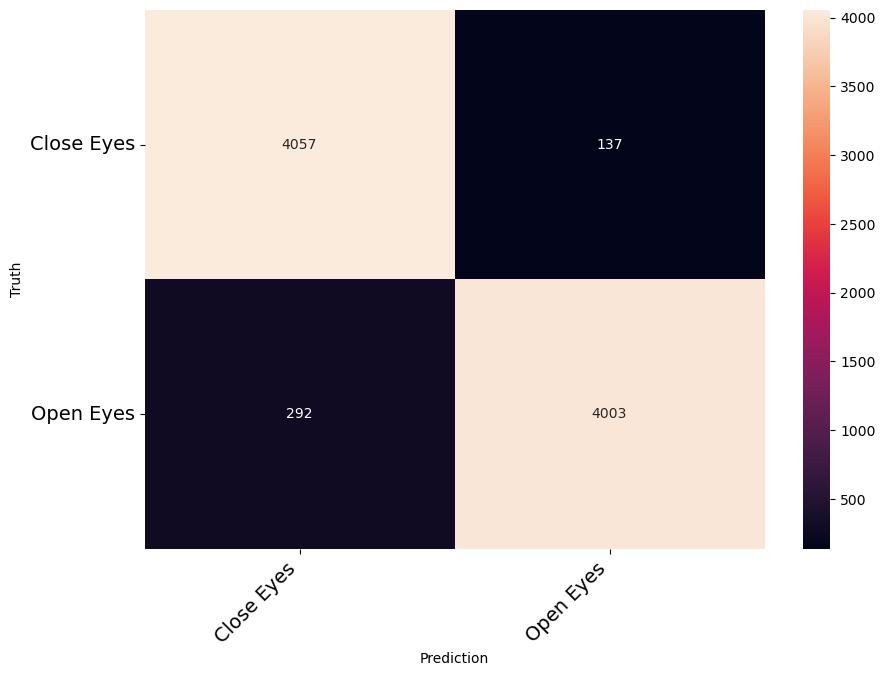

In [16]:
cm = confusion_matrix(test_data.classes, y_pred)
print_confusion_matrix(cm,["Close Eyes","Open Eyes"])

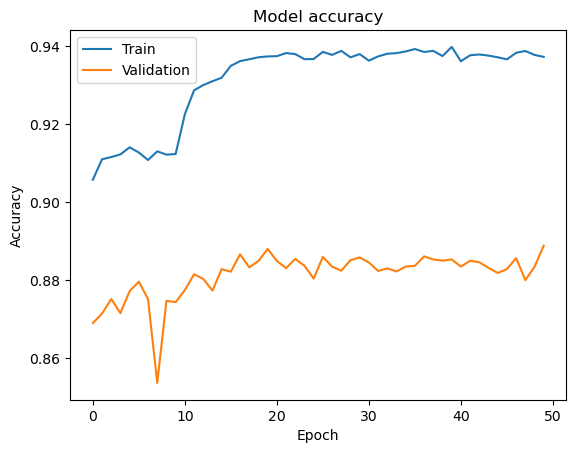

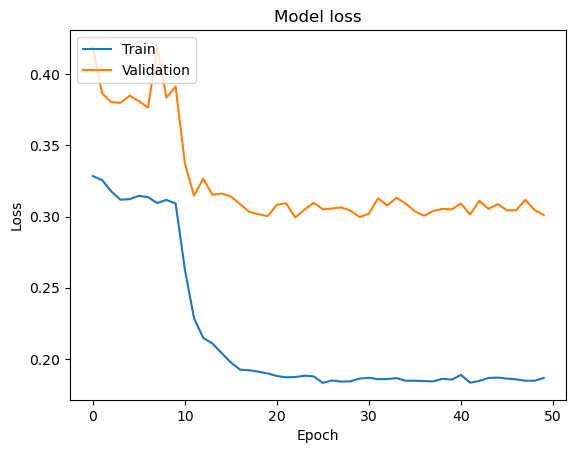

In [17]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(train_model.history['accuracy'])
plt.plot(train_model.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(train_model.history['loss'])
plt.plot(train_model.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Using haarcascade pretrained xml file for detecting face and eyes.

In [22]:
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model
import numpy as np

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades 
                                     + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades
                                    + 'haarcascade_eye.xml')
model = load_model(r'C:\Users\USER\.conda\DD_using_mobilenet_model.h5')

The variable "Score" is used to keep track of the time frame in seconds.

Initially, when the program starts running, the value of Score is set to 0.

If the prediction value is less than 0.50, which indicates that the eyes are closed, then the Score is incremented by 1 second each time in the loop.

Once the Score reaches 5 seconds (Score > 4), the program displays "Drowsiness detected !" on the video frame.

Therefore, it will take 5 seconds of continuously closed eyes for the program to say "Drowsiness detected !".

In [23]:
cap = cv2.VideoCapture(0)
Score = 0
while True:
    ret, frame = cap.read()
    height,width = frame.shape[0:2]
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces= face_cascade.detectMultiScale(gray, scaleFactor= 1.2, minNeighbors=3)
    eyes= eye_cascade.detectMultiScale(gray, scaleFactor= 1.1, minNeighbors=1)
    
    cv2.rectangle(frame, (0,height-50),(290,height),(0,0,0),thickness=cv2.FILLED)
    cv2.rectangle(frame, (0,height-120),(290,height),(0,0,0),thickness=cv2.FILLED)
    
    for (x,y,w,h) in faces:
        cv2.rectangle(frame,pt1=(x,y),pt2=(x+w,y+h), color= (255,0,0), thickness=3 )
        
    for (ex,ey,ew,eh) in eyes:
        #cv2.rectangle(frame,pt1=(ex,ey),pt2=(ex+ew,ey+eh), color= (0,0,255), thickness=3 )
        
        # preprocessing steps
        eye= frame[ey:ey+eh,ex:ex+ew]
        eye= cv2.resize(eye,(80,80))
        eye= eye/255
        eye= eye.reshape(80,80,3)
        eye= np.expand_dims(eye,axis=0)
        # preprocessing is done now model prediction
        prediction = model.predict(eye)
        print(prediction)
        
        # if eyes are closed
        if prediction[0]<0.50:
            cv2.putText(frame,'Eyes Closed',(30,height-20),
                        fontFace=cv2.FONT_HERSHEY_COMPLEX_SMALL,
                        fontScale=1,color=(255,255,255),
                       thickness=1,lineType=cv2.LINE_AA)
            cv2.putText(frame,str(Score)+' seconds',(170,height-20),
                        fontFace=cv2.FONT_HERSHEY_COMPLEX_SMALL,
                        fontScale=1,color=(255,255,255),
                       thickness=1,lineType=cv2.LINE_AA)
            Score=Score+1
            if(Score>4):
                cv2.putText(frame,'Drowsiness Detected !',(30,height-90),
                            fontFace=cv2.FONT_HERSHEY_COMPLEX_SMALL,
                            fontScale=1,color=(0,0,255),
                       thickness=1,lineType=cv2.LINE_AA)               
            
        # if eyes are open
        elif prediction[0]>0.80:
            cv2.putText(frame,'Eyes Are Open',(30,height-50),
                        fontFace=cv2.FONT_HERSHEY_COMPLEX_SMALL,
                        fontScale=1,color=(0,255,0),
                       thickness=1,lineType=cv2.LINE_AA)

            Score = Score-1
            if (Score<0):
                Score=0
            
        
    cv2.imshow('frame',frame)
    if cv2.waitKey(33) & 0xFF==ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

[[0.93089163]]
[[0.6794847]]
[[0.51207954]]
[[0.99344385]]
[[0.84426343]]
[[0.6452131]]
[[0.36484423]]
[[0.10508302]]
[[0.5948912]]
[[0.8882825]]
[[0.3141153]]
[[0.90084887]]
[[0.45116758]]
[[0.9227368]]
[[0.9038184]]
[[0.96846706]]
[[0.9254162]]
[[0.9914032]]
[[0.40006426]]
[[0.9525696]]
[[0.625813]]
[[0.77732265]]
[[0.84989285]]
[[0.6887804]]
[[0.8736822]]
[[0.56790185]]
[[0.9999957]]
[[0.9214424]]
[[0.94979656]]
[[0.95519334]]
[[0.06368133]]
[[0.9998336]]
[[0.72382694]]
[[0.8825799]]
[[0.9680482]]
[[0.24627608]]
[[0.997829]]
[[0.98792297]]
[[0.24627608]]
[[0.99983025]]
[[0.99067795]]
[[0.99930865]]
[[0.64743364]]
[[0.99219215]]
[[0.98706514]]
[[0.9738767]]
[[0.8345523]]
[[0.93064237]]
[[0.64797735]]
[[0.981431]]
[[0.7942014]]
[[0.6694549]]
[[0.7369847]]
[[0.9782653]]
[[0.99743986]]
[[0.94660425]]
[[0.34414592]]
[[0.9959787]]
[[0.09322995]]
[[0.95868784]]
[[0.90821606]]
[[0.9683074]]
[[0.8357655]]
[[0.8357655]]
[[0.92312205]]
[[0.47527277]]
[[0.6396342]]
[[0.7238208]]
[[0.86046124]]
